# Reversible Dimerization Example (Gillespie)

This notebook demonstrates:
1. A bounded reaction model: A + B <-> AB
2. Continuous-time sampling with Gillespie
3. Measurement before state modification
4. Basic analysis of the resulting trajectory

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Random
using StatsBase
using MonteCarloX

  Activating project at `~/.julia/dev/MonteCarloX/notebooks`


## Reversible dimer model

In [2]:
mutable struct ReversibleDimerModel <: AbstractSystem
    A::Int
    B::Int
    AB::Int
    k_on::Float64
    k_off::Float64
end

# Event 1: association A + B -> AB
# Event 2: dissociation AB -> A + B
reaction_rates(sys::ReversibleDimerModel, t::Real) = [
    sys.k_on * sys.A * sys.B,
    sys.k_off * sys.AB
]

function modify!(sys::ReversibleDimerModel, event::Int, t::Real)
    if event == 1
        if sys.A > 0 && sys.B > 0
            sys.A -= 1
            sys.B -= 1
            sys.AB += 1
        end
    elseif event == 2
        if sys.AB > 0
            sys.A += 1
            sys.B += 1
            sys.AB -= 1
        end
    end
    return sys
end

modify! (generic function with 1 method)

## Setup algorithm and measurements

In [3]:
rng = MersenneTwister(23)
sys = ReversibleDimerModel(30, 30, 0, 0.01, 0.5)
alg = Gillespie(rng)

T = 200.0
measurement_times = collect(0.0:0.5:T)
measurements = Measurements([
    :A => (s -> s.A) => Int[],
    :B => (s -> s.B) => Int[],
    :AB => (s -> s.AB) => Int[]
], measurement_times)

measure!(measurements, sys, alg.time)
println("Initial state: A=$(sys.A), B=$(sys.B), AB=$(sys.AB)")

Initial state: A=30, B=30, AB=0


## Run continuous-time simulation
`step!` advances time and increments `alg.steps`, returning `(t_new, event)`.
Measurements are evaluated after time advance and before state modification.

In [4]:
while alg.time <= T
    t_new, event = step!(alg, t -> reaction_rates(sys, t))
    measure!(measurements, sys, t_new)
    modify!(sys, event, t_new)
end

println("Final simulated time: $(round(alg.time, digits=3))")
println("Final state: A=$(sys.A), B=$(sys.B), AB=$(sys.AB)")
println("Events sampled: $(alg.steps)")

Final simulated time: 200.146
Final state: A=22, B=22, AB=8
Events sampled: 1824


## Analyze trajectory

In [5]:
A_traj = measurements[:A].data
B_traj = measurements[:B].data
AB_traj = measurements[:AB].data

println("Measured samples: $(length(AB_traj))")
println("Mean A:  $(round(mean(A_traj), digits=3))")
println("Mean B:  $(round(mean(B_traj), digits=3))")
println("Mean AB: $(round(mean(AB_traj), digits=3))")

Measured samples: 401
Mean A:  20.97
Mean B:  20.97
Mean AB: 9.03


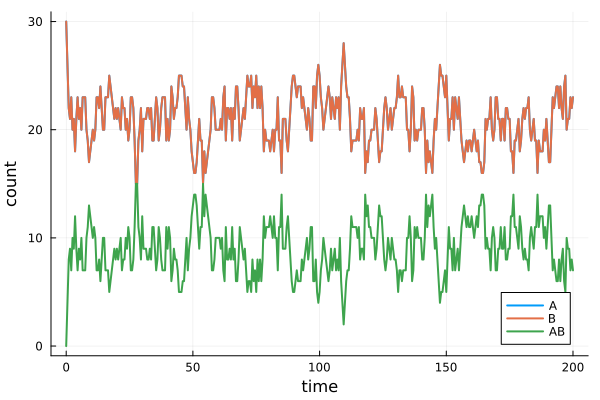

In [6]:
using Plots
plot(measurement_times, A_traj, xlabel="time", ylabel="count", label="A", lw=2)
plot!(measurement_times, B_traj, label="B", lw=2)
plot!(measurement_times, AB_traj, label="AB", lw=2)